Persian Handwriting K-Means

In [1]:
# Import Libraries
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.io
import cv2


In [2]:
import struct

with open('dataset/Test_20000.cdb', 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        print("yy :",yy)
        offset += 2
        
        m = struct.unpack_from('B', data, offset)[0]
        print("m :",m)
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        print("d : ", d)
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        print(TotalRec)
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)        
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False
        
        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)
            
            
            

yy : 2005
m : 8
d :  4
20000


shape of image is :  (29, 22)
label of image is: 7
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  255 255   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255
  255 255 255   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255
  255 255 255 255]
 [255 255 255   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255
  255 255 255 255]
 [255 255 255   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255
  255 255 255   0]
 [  0 255 255   0   0   0   0   0   0   0   0   0   0   0   0   0 255 255
  255 255 255   0]
 [  0 255 255 255   0   0   0   0   0   0   0   0   0   0   0 255 255 255
  255 255   0   0]
 [  0 255 255 255   0   0   0   0   0   0   0   0   0   0   0 255 255 255
  255   0   0   0]
 [  0 255 255 255   0   0   0   0   0   0   0   0   0   0 255 255 255 255
  255   0   0   0]
 [  0 255 255 255   0   0   0   0   0   0   0   0   0 255 255 255 255 255
    0   0   0   0]
 [  0 255 255 255 2

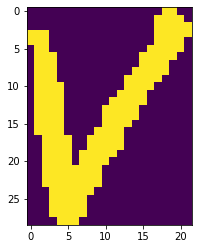

In [3]:
im=15000

l=labels[im]
z=images[im]
print("shape of image is : " ,z.shape)
print("label of image is:",l)
print(z)
plt.imshow(z)

In [4]:

def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image



images_height=32
images_width=32
one_hot=False
reshape=True
    
assert len(images) == len(labels)

X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
Y = np.zeros(shape=[len(labels)], dtype=np.int)

for i in range(len(images)):
    image = images[i]
    # Image resizing.
    image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
    # Image normalization.
    image = image / 255
    # Image binarization.
    image = np.where(image >= 0.5, 1, 0)
    # Image.
    X[i] = image
    # Label.
    Y[i] = labels[i]

if one_hot:
    Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
else:
    Y = Y.astype(dtype=np.float32)

# if reshape:
#     X = X.reshape(-1, images_height * images_width)
# else:
#     X = X.reshape(-1, images_height, images_width, 1)



(32, 32)


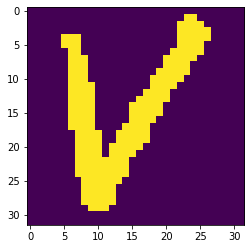

In [5]:
xx=X[15000]
print(xx.shape)
plt.imshow(xx)